# Measuring RMSF of C22 

In [20]:
from pmda.rms import RMSF
import MDAnalysis as mda
from MDAnalysis.analysis import align
name = "CHL.AMB"
e=1

u = mda.Universe("/Scr/arango/ergosterol-amb/1-WorkflowDevelopment/5-forpaper/"+str(name)+".0/min/1.psf", "/Scr/arango/ergosterol-amb/1-WorkflowDevelopment/5-forpaper/"+str(name)+".0/min/1.min.dcd")
calphas = u.select_atoms("resname AMB and name C22")

rmsfer = RMSF(calphas).run(n_blocks=12)

/Projects/arango/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


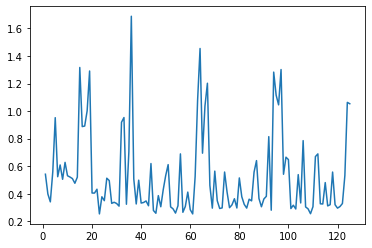

In [7]:
import matplotlib.pyplot as plt
plt.plot(calphas.resnums, rmsfer.rmsf)

In [3]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import cpu_count

n_jobs = cpu_count()

name = "CHL.AMB"
e = 1
u = mda.Universe("/Scr/arango/ergosterol-amb/1-WorkflowDevelopment/5-forpaper/"+str(name)+".0/min/1.psf", "/Scr/arango/ergosterol-amb/1-WorkflowDevelopment/5-forpaper/"+str(name)+".0/min/1.min.dcd")
protein = u.select_atoms("resname AMB and name C22")

In [22]:
import nglview as nv
w = nv.show_mdanalysis(protein)
w

/Projects/arango/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/Projects/arango/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/Projects/arango/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/Projects/arango/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:1028: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))
/Projects/arango/anaconda3/lib/python3.6/site-packages/MDAnalysis/core/topologyattrs.py:2011: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (wh

NGLWidget(count=50)

In [5]:
def radgyr_per_frame(frame_index, atomgroup, masses, total_mass=None):

    # index the trajectory to set it to the frame_index frame
    atomgroup.universe.trajectory[frame_index]

    # coordinates change for each frame
    coordinates = atomgroup.positions
    center_of_mass = atomgroup.center_of_mass()

    # get squared distance from center
    ri_sq = (coordinates-center_of_mass)**2
    # sum the unweighted positions
    sq = np.sum(ri_sq, axis=1)
    sq_x = np.sum(ri_sq[:,[1,2]], axis=1) # sum over y and z
    sq_y = np.sum(ri_sq[:,[0,2]], axis=1) # sum over x and z
    sq_z = np.sum(ri_sq[:,[0,1]], axis=1) # sum over x and y

    # make into array
    sq_rs = np.array([sq, sq_x, sq_y, sq_z])

    # weight positions
    rog_sq = np.sum(masses*sq_rs, axis=1)/total_mass
    # square root and return
    return np.sqrt(rog_sq)

In [24]:
import multiprocessing
from multiprocessing import Pool
from functools import partial


In [28]:
run_per_frame = partial(radgyr_per_frame,
                        atomgroup=protein,
                        masses=protein.masses,
                        total_mass=np.sum(protein.masses))

frame_values = np.arange(u.trajectory.n_frames)

In [30]:
with Pool(n_jobs) as worker_pool:
    result = worker_pool.map(run_per_frame, frame_values)

OSError: Reading DCD header failed: format of DCD file is wrong

In [27]:
frames = [ts.frame for ts in u.trajectory]
print(frames)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


# DASK 

In [1]:
import dask
import dask.multiprocessing
dask.config.set(scheduler='processes')

In [4]:
from dask.distributed import Client

client = Client(n_workers=n_jobs)
client

Client Scheduler: tcp://127.0.0.1:34673 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 32 Cores: 32 Memory: 404.08 GB


In [6]:
job_list = []
for frame_index in range(u.trajectory.n_frames):
    job_list.append(dask.delayed(radgyr_per_frame(frame_index,
                                        atomgroup=protein,
                                        masses=protein.masses,
                                        total_mass=np.sum(protein.masses))))

In [7]:
result = dask.compute(job_list)

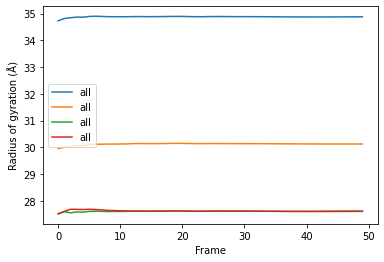

In [11]:
result = np.asarray(result).T

labels = ['all', 'x-axis', 'y-axis', 'z-axis']
for col, label in zip(result, labels):
    plt.plot(col, label=label)
plt.legend()
plt.ylabel('Radius of gyration (Å)')
plt.xlabel('Frame');

In [14]:
dask.distributed.Client

distributed.client.Client